In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
chars = sorted(list(set(''.join(words))))D
stoi =  {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
# build the dataset

block_size = 3  # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:

    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 4]), torch.int64, torch.Size([228146]), torch.int64)

In [8]:
# build the dataset

def build_dataset(words, block_size= 3):
    X, Y  = [], []
    for w in words:

        #print w
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1], block_size=4)
Xdev, Ydev = build_dataset(words[n1:n2], block_size=4)
Xte, Yte = build_dataset(words[n2:], block_size=4)

torch.Size([182625, 4]) torch.Size([182625])
torch.Size([22655, 4]) torch.Size([22655])
torch.Size([22866, 4]) torch.Size([22866])


In [9]:
C = torch.randn((27,2))

In [10]:
emb = C[X]
emb.shape

torch.Size([228146, 4, 2])

In [11]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [12]:
h = torch.tanh(emb.view(-1 ,6) @ W1 + b1) 

RuntimeError: shape '[-1, 6]' is invalid for input of size 1825168

In [13]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [14]:
logits = h @ W2 + b2

NameError: name 'h' is not defined

In [22]:
logits.shape

torch.Size([32, 27])

In [23]:
counts = logits.exp()

In [24]:
prob = counts/counts.sum(1, keepdims=True)

In [25]:
loss = -prob[torch.arange(32),Y].log().mean()

In [26]:
# ---------------------------- ORDER -------------------------------------

In [15]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 4]), torch.Size([182625]))

In [16]:
# parameters
g = torch.Generator().manual_seed(214783647)
C = torch.randn((27,8), generator=g)
W1 = torch.randn((32,250), generator=g)
b1 = torch.randn(250, generator=g)
W2 = torch.randn((250,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [17]:
sum(p.nelement() for p in parameters) # Parameter count

15243

In [18]:
for p in parameters:
    p.requires_grad = True

In [19]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [20]:
lri = []
lossi = []
stepi = []

In [21]:


for i in range(300000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1 ,32) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits,Ytr[ix])
    #print(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    #lr = lre[i]
    lr = 0.1 if i < 100000 else 0.05 if i < 200000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

# partial loss
#print(loss.item())

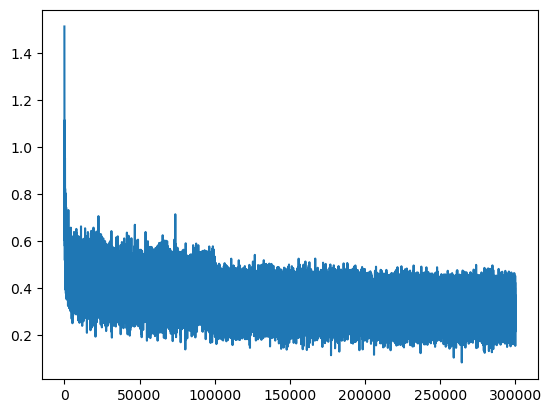

In [22]:
plt.plot(stepi,lossi)

In [23]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1 ,32) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits,Ytr)
loss.item()

2.117949962615967

In [24]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1 ,32) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits,Ydev)
loss.item()

2.1659867763519287

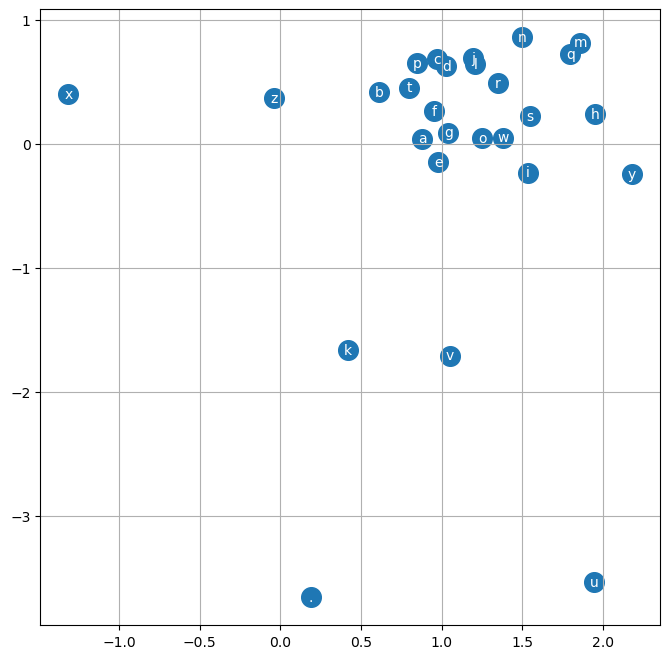

In [25]:
plt.figure(figsize =(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [26]:
# training split, dev or validation, test split 
# 80%, 10%, 10%
# optimzie, development of hyper parameters, evaluate the model
# dont test too often on test split or it may overfit


In [27]:
#sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * 4
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

mona.
kayan.
seel.
niyah.
lorethan.
endra.
gradelynneli.
jemi.
jenleigh.
estanar.
kayzlynn.
alin.
shub.
rilaighel.
kendreelynn.
nocalyn.
bren.
dariyah.
fael.
yume.
